# AKTI - MLP
Vytvoříme MLP se dvou fully-connected vrstev, který dokáže rozpoznat ručně psané číslice s přesností nad 95%.

## Krok 1: Importy

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

### Proč importujeme co

- **import torch** - obsahuje hlavní datovou strukturu PyTorch – *Tenzor* – a všechny základní matematické operace. Tenzory jsou optimalizované pro výpočty na GPU.
- **import torch.nn as nn** - modul nn (neural networks) poskytuje všechny stavební bloky, které potřebujeme pro vytvoření MLP: lineární vrstvy **nn.Linear**, aktivační funkce **nn.Relu** a další. Každý model, který budeme psát, bude dědit z **nn.Module**
- **import torch.optim as optim** - obsahuje algoritmy pro trénink sítě jako *SGD* nebo *Adam*. Ty aktualizují váhy v modelu během backpropagation.
- **from torchvision import datasets, transforms** - usnadňuje práci s obrázky. **datasets** obsahuje předpřipravené datasety (pro nás je důležity **MNIST** (číslice), **transforms** obsahuje nástroje transformaci dat (převod obrázku na tenzor + normalizace)
- **from torch.utils.data import DataLoader** - nástroj na efektivní správu dat během tréninku (rozděluje data na menší dávky (*batche*), náhodně míchá data (*shuffling*), paralelizuje načítání dat.
- **from sklearn.metrics import accuracy_score** - používáme knihovnu Scikit-learn (i když většina se dělá v PyTorch), abychom získali standardizovanou funkci pro rychlý výpočet přesnosti (*accuraccy*) našeho modelu.
- **import numpy as np** - základní knihovna pro práci s poli v Pythonu. Použijeme ho pro úvodní manipulaci s daty a pro převod tenzorů na standardní formát, se kterým umí pracovat např  matplotlib neb sklearn.

- **import matplotlib.pyplot as plt** -- Matplotlib je nejrozšířenější knihovna v Pythonu pro vytváření statických, animovaných a interaktivních vizualizací. Tuto knihovnu potřebujeme k tomu, abychom mohli graf chybové funkce a zobrazit MNIST obrázky
 

## Krok 2: Konfigurace

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 28 * 28  # 784 pixelů
HIDDEN_SIZE = 128
NUM_CLASSES = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 10

### O co tady jde
**Výběr zařízení:** určuje, zda se výpočty (trénink a predikce) budou provádět na GPU (CUDA) nebo na CPU:
- Pokud je GPU dostupné **torch.cuda.is_available()**, použije se GPU, které je pro NN výpočty mnohem rychlejší.
- Jinak se automaticky přepne na CPU.

**INPUT_SIZE** - určuje velikost vstupu do sítě. Protože pracujeme s obrázky MNIST, které mají rozměr $28 \times 28$ pixelů, síť přijímá $784$ vstupních hodnot (pixelů).

**HIDDEN_SIZE** - definuje počet neuronů v každé ze skrytých vrstev našeho MLP. Tato hodnota určuje "šířku" nebo "kapacitu" sítě k učení se komplexním featurám.

**NUM_CLASSES** - počet výstupů = počet tříd, kterých má náš MPL klasifikovat. V našem případě je to 10 číslic (0 až 9). Výstupní vrstva musí mít přesně 10 neuronů.

**LEARNING_RATE** - řídí, jak velký krok provede optimalizátor při aktualizaci vah po každém zpětném průchodu (backpropagation). Malé hodnoty vedou k pomalému, ale stabilnímu učení; velké hodnoty mohou vést k nestabilitě.

**BATCH_SIZE** - velikost dávjy -- počet vzorků, které síť zpracuje najednou před provedením jedné aktualizace vah. Větší batche zrychlují trénink (díky GPU), ale vyžadují více paměti.

**EPOCHS** - určuje, kolikrát se celá trénovací sada dat (všech 60 000 obrázků) projde sítí tam a zpět. Počet epoch určuje celkovou délku tréninku.

## Krok 3: Načtení dat a normalizace
Tato sekce zajišťuje, že se surová data (obrázky) převedou do formátu, kterému PyTorch rozumí (Tenzory), a že se efektivně podávají síti.

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Transformace:
**transforms.Compose** spojuje více operací do jedné sekvence, kterou aplikujeme na každý obrázek. 
- **transforms.ToTensor()** převede obrázek z formátu PIL (standardní formát pro obrázky v Pythonu) na PyTorch Tenzor a automaticky škáluje hodnoty pixelů z rozsahu $0–255$ na $0–1$.
- **transforms.Normalize()** standardizuje data. Používá se k transformaci hodnot $0–1$ do rozsahu, který má průměr 0 a směrodatnou odchylku 1 (zde průměr 0.1307 a směrodatnou odchylku 0.3081, což jsou statistiky vypočtené z celého datasetu MNIST). Toto centruje data a usnadňuje trénink.

### Načtení datasetů
**Načtení MNIST:** Zde stahujeme a připravujeme data.
- **datasets.MNIST(...)** - používáme připravený dataset MNIST z **torchvision**.
- **train=True** / **train=False** - rozděluje data na trénovací sadu (pro učení) a testovací sadu (pro ověření přesnosti).
- **download=True** - zajistí, že se data stáhnou, pokud ještě nejsou lokálně uložena ve složce *./data*.
- **transform=transform** - aplikuje předdefinovanou sekvenci transformací na každý obrázek.

### Správa dat
**DataLoader** - tyto objekty jsou iterátory, které efektivně dodávají data MLP během tréninku.
- **batch_size=...** určuje, kolik obrázků se pošle najednou (definováno proměnnou *BATCH_SIZE*).
- **shuffle=True** - u trénovací sady náhodně promícháme data v každé epoše, což je zásadní pro zajištění, že se síť neučí jen pořadí dat.
- **shuffle=False** - u testovací sady náhodné promíchání nepotřebujeme; stačí nám data procházet v původním pořadí.

## Krok 4: Definice MLP architektury
Každý model v PyTorch musí být definován jako třída, která dědí z **nn.Module**. Tato třída má dvě povinné části:
- konstruktor **__init__** 
- metodu dopředného průchodu **forward**

In [42]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layer_1 = nn.Linear(INPUT_SIZE, HIDDEN_SIZE)
        self.layer_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.output_layer = nn.Linear(HIDDEN_SIZE, NUM_CLASSES)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.output_layer(x)
        return x

Definujeme třídu **SimpleMLP**, která dědí funkcionalitu od **nn.Module** (např. automatické sledování parametrů pro backpropagation).

### Konstruktor: 
Zde pouze říkáme síti, jaké moduly (vrstvy s vahami) bude obsahovat. V této fázi se nic nepočítá, pouze se inicializují parametry.
- Volání **super()** je povinné.
- První skrytá vrstva: používáme **nn.Linear**, což je plně propojená vrstva (každý neuron z *INPUT_SIZE* je propojen s každým neuronem z *HIDDEN_SIZE*. Převádíme 'zploštělý' obrázek (784 pixelů) na 128 neuronů.
- Druhá skrytá vrstva: generuje finálních 10 logitů (hodnot), jednu pro každou třídu (číslici 0 až 9).
- Aktivační funkce: definujeme **ReLU** (Rectified Linear Unit), což je nelineární funkce, která se bude aplikovat po lineárních vrstvách.

### Dopředný průchod:
Tato metoda definuje, jak data *skutečně protékají* sítí.
- Zploštění (*flattening*): stupní data z DataLoaderu jsou ve formátu $(Dávka, 1, 28, 28)$ (dávka, kanály, výška, šířka). Naše MLP přijímá pouze ploché vektory, proto musíme data zploštit na $(Dávka, 784)$. Argument *-1* říká PyTorchu, aby automaticky vypočítal 784.
- Průtok dat: Data *x* procházejí sekvenčně: nejprve lineární transformací, a poté je aplikována nelineární funkce **ReLU**.
- Výstup: Data projdou poslední lineární vrstvou. Výsledkem jsou finální *logity* – surové skóre pro každou z 10 tříd. Tyto logity se následně použijí pro výpočet chyby (**CrossEntropyLoss**).

In [53]:
model = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Vytvoření instance
- **SimpleMLP()** volá konstruktor, vytvoří instanci naší sítě a inicializuje všechny váhy.
- **.to(device)** vezme celý model (včetně všech vah) a přesune ho na dříve určené zařízení.

### Chybová funkce
- **nn.CrossEntropyLoss()** (*Křížová entropie*) je nejpoužívanější chybová funkce pro úlohy *více-třídní klasifikace* (Multi-Class Classification), jako je MNIST.

- Měří "vzdálenost" mezi *výstupními logity* sítě a *skutečnými labely*. Cílem tréninku je tuto vzdálenost minimalizovat.

- Nebudeme ji víc rozebírat, je to záležitost předmětů *KMI/UMIN* či *KMI/TINF*.

### Optimalizátor
- **optim.Adam** je moderní, efektivní a velmi oblíbený optimalizační algoritmus (alternativa k tradičnímu SGD).
- **model.parameters()** - optimalizátoru, které proměnné (váhy a biasy) má sledovat a aktualizovat během backpropagation.
- **lr=LEARNING_RATE** definuje rychlost učení, kterou má Adam použít pro úpravu vah.

## Krok 5: Trénovací a testovací smyčka

In [62]:
for epoch in range(EPOCHS):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # 1. Přesun dat na zařízení
        data, target = data.to(device), target.to(device)
        
        # 2. Nulování gradientů
        optimizer.zero_grad()
        
        # 3. Dopředný průchod (Forward Pass)
        output = model(data)
        
        # 4. Výpočet chybu (Loss)
        loss = criterion(output, target)
        
        # 5. Zpětná propagace (Backward Pass)
        loss.backward()
        
        # 6. Aktualizace vah
        optimizer.step()

    # Testování na konci epochy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Predikce je index s nejvyšší hodnotou
            _, predicted = torch.max(output.data, 1) 
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{EPOCHS}, Test Accuracy: {accuracy:.2f}%')

Epoch 1/10, Test Accuracy: 97.72%
Epoch 2/10, Test Accuracy: 97.52%
Epoch 3/10, Test Accuracy: 98.00%
Epoch 4/10, Test Accuracy: 97.89%
Epoch 5/10, Test Accuracy: 97.86%
Epoch 6/10, Test Accuracy: 97.89%
Epoch 7/10, Test Accuracy: 97.54%
Epoch 8/10, Test Accuracy: 97.66%
Epoch 9/10, Test Accuracy: 97.87%
Epoch 10/10, Test Accuracy: 97.47%


### A. Trénovací fáze (učení vah)

- **Vnější smyčka** (**for epoch...**) definuje počet průchodů celé trénovací sady dat.

- **Trénovací mód** (**model.train()**) přepne model do trénovacího módu. 

- **Vnitřní smyčka** (**for batch_idx...**): Iteruje přes DataLoader, který dodává data po menších dávkách (batchích).

- **Přesun dat** - data a labely se musí explicitně přesunout na stejné zařízení (device), na kterém je model.

- **Vynulování gradientů** (**optimizer.zero_grad()**): PyTorch ve výchozím nastavení sčítá gradienty z různých kroků. Před každou novou dávkou musíme gradienty vynulovat, abychom zajistili, že síť trénuje jen s gradienty z aktuální dávky.

- **Dopředný průchod** (**output = model(data)**): Data procházejí sítí a model vrací výstupní logity.

- **Výpočet chyby** (**loss = criterion(output, target)**): Loss funkce porovná výstup sítě s pravdivými labely a kvantifikuje chybu.

- **Zpětná propagace** (**loss.backward()**): Automaticky vypočítá gradienty (derivace) Loss funkce vzhledem ke *všem vahám* v síti.

- **Aktualizace vah** (**optimizer.step()**): optimalizátor použije spočítané gradienty k upravení vah modelu. Tím dochází k učení.

### B. Testovací fáze

- **Evaluační mód** (**model.eval()**): přepne model do testovacího módu 

- **Vypnutí gradientů** (**with torch.no_grad()**): Při testování nepotřebujeme počítat ani ukládat gradienty. Toto vypnutí výrazně šetří paměť a zrychluje výpočet.

- **Predikce** (**torch.max(output.data, 1)**): Z logitů na výstupu se vybere index s nejvyšší hodnotou (index s nejvyšší pravděpodobností), což je finální predikce sítě.

- **Výpis přesnosti:** Spočítá se celková přesnost na testovací sadě.

 ## Krok 6: Závěrečná Vizualizace
 Tato funkce slouží k vizuálnímu ověření, že natrénovaný model MLP skutečně správně rozpoznává ručně psané číslice.

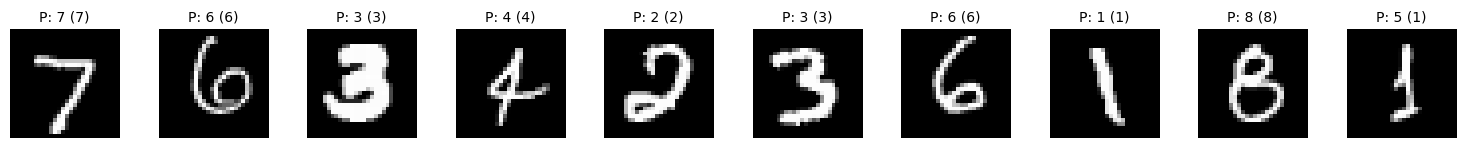

In [80]:
def visualize_predictions(model, test_dataset, device, num_samples=10):
    model.eval()
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 1.5))
    
    for i in range(num_samples):
        # Získání náhodného vzorku
        image, label = test_dataset[i * 100] # Vezmeme vzorek z různých míst
        
        # Predikce
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            prediction = torch.argmax(output).item()
        
        # Zobrazení
        axs[i].imshow(image.cpu().squeeze(), cmap='gray')
        axs[i].set_title(f'P: {prediction} ({label})', fontsize=10)
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Spuštění vizualizace
visualize_predictions(model, test_dataset, device)

Definuje se funkce, která vezme model a testovací data.
- **model.eval()** přepne síť do testovacího módu.
- **plt.subplots** připraví řádek pro zobrazení 10 obrázků.
- Procházíme 10 vzorků. **test_dataset[i * 100]** vybere 10 vzorků, které jsou dostatečně daleko od sebe, aby byly různorodé.
- **with torch.no_grad()** - už nechceme síť učit.
- **image.unsqueeze(0)** - Model vždy očekává data ve formátu $(Dávka, \dots)$. Zde bereme pouze jeden obrázek, takže musíme přidat prázdnou dimenzi pro dávku (Batch Size), aby to vypadalo jako $(1, 1, 28, 28)$.
- **.to(device)**: Přesuneme obrázek na stejné zařízení (GPU/CPU) jako model.
- **output = model(..)** spustí dopředný průchod.
- **torch.argmax(output).item()**: Z logitů na výstupu (10 čísel) vybere index s *nejvyšší hodnotou* (maximum), což je číslo, které síť predikuje. *.item()* převede výsledek z tenzoru na standardní Python číslo.
- **axs[i].imshow(...)** zobrazí původní obrázek. 
- **.cpu().squeeze()** převede tenzor zpět do formátu s jedním kanálem vhodného pro zobrazení.
- Titulek: Ukazuje **P**redikci sítě (*prediction*) a v závorkách *skutečný label*
- **plt.show()** vykreslí finální mřížku